## 1. Data Preprocessing

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from IPython.display import Image

In [0]:
## data 불러오기
TRAIN = pd.read_csv('data/AFSNT.csv', encoding='CP949')
TEST = pd.read_csv('data/AFSNT_DLY.csv', encoding='CP949')
SCHEDULE = pd.read_csv('data/SFSNT.csv', encoding='CP949')

In [0]:
TRAIN.head(3)

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR
0,2017,1,1,일,ARP3,ARP6,J,J1955,SEw3NzE4,D,N,10:05,10:32,N,NaN,N,NaN
1,2017,1,1,일,ARP3,ARP6,J,J1954,SEw3NzE4,A,N,9:30,9:31,N,NaN,N,NaN
2,2017,1,1,일,ARP3,ARP6,J,J1956,SEw3NzE4,A,N,12:45,13:03,N,NaN,N,NaN


In [0]:
TEST.head(3)

,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,월,ARP1,ARP3,L,L1702,A,9:05,NaN,NaN
1,2019,9,16,월,ARP3,ARP1,L,L1702,D,7:55,NaN,NaN
2,2019,9,16,월,`,ARP3,L,L1720,A,14:40,NaN,NaN


In [0]:
# test data 오타 수정 (빅콘테스트 홈페이지 Q&A 참고)
TEST['ARP'][2] = 'ARP1'
TEST.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,SDT_YY,SDT_MM,SDT_DD,SDT_DY,ARP,ODP,FLO,FLT,AOD,STT,DLY,DLY_RATE
0,2019,9,16,월,ARP1,ARP3,L,L1702,A,9:05,NaN,NaN
1,2019,9,16,월,ARP3,ARP1,L,L1702,D,7:55,NaN,NaN
2,2019,9,16,월,ARP1,ARP3,L,L1720,A,14:40,NaN,NaN


### 1-1. TEST 데이터에 부정기편 변수 추가하기

In [0]:
# SCEHDULE(SFSNT.csv)를 통한 부정기편 확인
SCHEDULE[SCHEDULE['IRR'] == 'Y']

,SSC,FLT,ORG,DES,STD,STA,FLO,MON,TUE,WED,THU,FRI,SAT,SUN,FSD,FED,IRR
568,S19,H1876,ARP3,ARP6,17:15,18:25,H,Y,Y,Y,Y,Y,Y,Y,20190503,20191026,Y
569,S19,H1875,ARP6,ARP3,19:00,20:10,H,Y,Y,Y,Y,Y,Y,Y,20190503,20191026,Y
597,S19,L1813,ARP4,ARP3,15:30,16:30,L,NaN,NaN,NaN,NaN,Y,NaN,NaN,20190723,20190831,Y
762,S19,B1806F,ARP4,ARP1,21:15,22:15,B,NaN,Y,NaN,NaN,NaN,NaN,NaN,20190603,20191026,Y
835,S19,L1811,ARP4,ARP3,7:40,8:45,L,NaN,Y,NaN,Y,NaN,Y,NaN,20190723,20190831,Y
836,S19,H1913F,ARP4,ARP7,21:00,21:50,H,NaN,NaN,Y,NaN,NaN,NaN,NaN,20190724,20190807,Y
837,S19,H1913F,ARP4,ARP7,5:35,6:25,H,NaN,NaN,NaN,NaN,NaN,NaN,Y,20190724,20190807,Y
838,S19,H1913F,ARP7,ARP4,9:25,10:15,H,NaN,NaN,Y,NaN,NaN,NaN,NaN,20190724,20190807,Y
900,S19,H1913F,ARP7,ARP4,9:05,9:55,H,NaN,NaN,NaN,NaN,NaN,Y,NaN,20190724,20190807,Y
982,S19,L1812,ARP3,ARP4,11:00,12:00,L,NaN,Y,NaN,Y,NaN,Y,NaN,20190723,20190831,Y


In [ ]:
# SCHEDULE에서 부정기편인 몇개 있는지 확인 --> 부정기편 데이터 없음
SCHEDULE_FLT = list(set(SCHEDULE[SCHEDULE['IRR']=='Y']['FLT']))
TEST_FLT = list(set(TEST['FLT']))
cnt = 0
for i in range(len(SCHEDULE_FLT)):
    for j in range(len(TEST_FLT)):
        if SCHEDULE_FLT[i] == TEST_FLT[j]:
            cnt += 1
print('부정기편의 개수:', cnt)

In [0]:
# TEST 데이터의 IRR 변수에 모두 'N' 넣기
TEST_IRR = TEST
TEST_IRR['IRR'] = 'N'

### 1-2. AOD를 출발(D) 기준으로 공항(ARP) 및 상대공항(ODP) 정리

In [0]:
# 필요한 변수만 뽑기
TRAIN_ = TRAIN[['SDT_YY', 'SDT_MM', 'SDT_DD', 'SDT_DY', 'ARP', 'ODP', 'FLO', 'FLT', 'AOD', 'STT', 'IRR', 'DLY']]
TEST_ = TEST_IRR[['SDT_YY', 'SDT_MM', 'SDT_DD', 'SDT_DY', 'ARP', 'ODP', 'FLO', 'FLT', 'AOD', 'STT', 'IRR', 'DLY']]

In [0]:
# 메모리 용량 확보를 위한 불필요한 데이터 삭제
del TRAIN
del TEST
del TEST_IRR

In [0]:
# train + test 합치기
DATA = pd.concat([TRAIN_, TEST_], axis=0, ignore_index = True)

In [0]:
# 모두 출발 기준으로 공항 ARP, 상대공항 ODP 변경
arp_li = []; odp_li = []
for i in range(len(DATA)):
    if DATA['AOD'][i] == 'A':
        arp_li.append(DATA['ODP'][i])
        odp_li.append(DATA['ARP'][i])
    else:
        arp_li.append(DATA['ARP'][i])
        odp_li.append(DATA['ODP'][i])
DATA['ARP'] = arp_li
DATA['ODP'] = odp_li
del DATA['AOD']

### 1-3. 계획시간대 변수 생성
- 추후 Feature Engineering에서 사용하기 위함

In [0]:
# STT 시간 변수 생성
stt_li = []
for i in range(len(DATA)):
    stt_li.append(DATA.STT[i][:-3])
DATA['STT_H'] = stt_li

## 2. Data Preprocessing
### 2-1. one-hot encoding 변수 생성

In [0]:
# pandas의 get_dummies를 이용한 범주형 변수의 one-hot encoding화
SDT_YY = pd.get_dummies(DATA['SDT_YY'], prefix='Y')
SDT_MM = pd.get_dummies(DATA['SDT_MM'], prefix='M')
SDT_DY = pd.get_dummies(DATA['SDT_DY'], prefix='D')
ARP = pd.get_dummies(DATA['ARP'], prefix='ARP')
ODP = pd.get_dummies(DATA['ODP'], prefix='ODP')
FLO = pd.get_dummies(DATA['FLO'], prefix='FLO')
STT_H = pd.get_dummies(DATA['STT_H'], prefix='H')
IRR = pd.get_dummies(DATA['IRR'], prefix='IRR')

In [0]:
# 예시 결과 (ARP)
ARP.head(3)

,ARP_ARP1,ARP_ARP10,ARP_ARP11,ARP_ARP12,ARP_ARP13,ARP_ARP14,ARP_ARP15,ARP_ARP2,ARP_ARP3,ARP_ARP4,ARP_ARP5,ARP_ARP6,ARP_ARP7,ARP_ARP8,ARP_ARP9
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [0]:
# 모든 onehot 변수 합치기
onehot = pd.concat([SDT_YY, SDT_MM, ARP, ODP, FLO, STT_H, IRR], axis=1)

In [0]:
# 합친 결과
onehot.head(3)

,Y_2017,Y_2018,Y_2019,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12,ARP_ARP1,ARP_ARP10,ARP_ARP11,ARP_ARP12,ARP_ARP13,ARP_ARP14,ARP_ARP15,ARP_ARP2,ARP_ARP3,ARP_ARP4,ARP_ARP5,ARP_ARP6,ARP_ARP7,ARP_ARP8,ARP_ARP9,ODP_ARP1,ODP_ARP10,ODP_ARP11,ODP_ARP12,ODP_ARP13,ODP_ARP14,ODP_ARP15,ODP_ARP2,ODP_ARP3,ODP_ARP4,...,ODP_ARP7,ODP_ARP8,ODP_ARP9,FLO_A,FLO_B,FLO_C,FLO_D,FLO_E,FLO_F,FLO_G,FLO_H,FLO_I,FLO_J,FLO_K,FLO_L,FLO_M,H_0,H_1,H_10,H_11,H_12,H_13,H_14,H_15,H_16,H_17,H_18,H_19,H_2,H_20,H_21,H_22,H_23,H_5,H_6,H_7,H_8,H_9,IRR_N,IRR_Y
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### 2-2. 항공사별 지연 비율 변수 생성

In [0]:
# 항공사별 지연 비율 계산
flo_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('FLO').count()['FLT'] / TRAIN_.groupby('FLO').count()['FLT']
flo_rate = flo_rate.fillna(0)

In [0]:
# 해당 행의 항공사에 대응하는 지연비율 대입
flo_li = []
for i in range(len(DATA)):
    cnt = 0
    for j in range(len(flo_rate)):
        if DATA['FLO'].iloc[i] == flo_rate.index[j]:
            cnt += 1
            flo_li.append(flo_rate.iloc[j])
    # train data에 해당 항공사가 없는 경우 0 추가
    if cnt == 0:
        flo_li.append(0)

In [0]:
# 변수 생성
onehot['FLO_RATE'] = flo_li

### 2-3. 공항 ARP / ODP별 지연 비율 변수 생성

In [0]:
# 공항별 지연 비율 계산
arp_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('ARP').count()['FLT'] / TRAIN_.groupby('ARP').count()['FLT']
arp_rate = arp_rate.fillna(0)

In [0]:
# 상대공항별 지연 비율 계산
odp_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('ODP').count()['FLT'] / TRAIN_.groupby('ODP').count()['FLT']
odp_rate = odp_rate.fillna(0)

In [0]:
# 해당 행의 공항에 대응하는 지연비율 대입
arp_list = []; odp_list = []
for i in range(len(DATA)):
    for j in range(1, 16):
        if DATA['ARP'][i] == 'ARP'+str(j):
            arp_list.append(arp_rate['ARP'+str(j)])
        if DATA['ODP'][i] == 'ARP'+str(j):
            odp_list.append(odp_rate['ARP'+str(j)])

In [0]:
# 변수 생성
onehot['ARP_RATE'] = arp_list
onehot['ODP_RATE'] = odp_list

### 2-4. 연도별 지연 비율 변수 생성

In [0]:
# 연도별 지연 비율 계산
year_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('SDT_YY').count()['FLT'] / TRAIN_.groupby('SDT_YY').count()['FLT']
year_rate = year_rate.fillna(0)

In [0]:
# 해당 행의 연도에 대응하는 지연비율 대입
year_li = []
for i in range(len(DATA)):
    cnt = 0
    for j in range(len(year_rate)):
        if DATA['SDT_YY'].iloc[i] == year_rate.index[j]:
            cnt += 1
            year_li.append(year_rate.iloc[j])
    # train data에 해당 없는 경우 0 추가
    if cnt == 0:
        year_li.append(0)

In [0]:
# 변수 생성
onehot['YEAR_RATE'] = year_li

### 2-5. 월별 지연 비율 변수 생성

In [0]:
# 월별 지연 비율 계산
month_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('SDT_MM').count()['FLT'] / TRAIN_.groupby('SDT_MM').count()['FLT']
month_rate = month_rate.fillna(0)

In [0]:
# 해당 행의 월에 대응하는 지연비율 대입
month_li = []
for i in range(len(DATA)):
    cnt = 0
    for j in range(len(month_rate)):
        if DATA['SDT_MM'].iloc[i] == month_rate.index[j]:
            cnt += 1
            month_li.append(month_rate.iloc[j])
    # train data에 해당 없는 경우 0 추가
    if cnt == 0:
        month_li.append(0)

In [0]:
# 변수 생성
onehot['MONTH_RATE'] = month_li

### 2-6. 요일별 지연 비율 변수 생성

In [0]:
# 요일별 지연 비율 계산
day_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('SDT_DY').count()['FLT'] / TRAIN_.groupby('SDT_DY').count()['FLT']
day_rate = day_rate.fillna(0)

In [0]:
# 해당 행의 요일에 대응하는 지연비율 대입
day_li = []
for i in range(len(DATA)):
    cnt = 0
    for j in range(len(day_rate)):
        if DATA['SDT_DY'].iloc[i] == day_rate.index[j]:
            cnt += 1
            day_li.append(day_rate.iloc[j])
    # train data에 해당 없는 경우 0 추가
    if cnt == 0:
        day_li.append(0)

In [0]:
# 변수 생성
onehot['DAY_RATE'] = day_li

### 2-7. 시간대별 지연 비율 변수 생성

In [0]:
# TRAIN 데이터에 대한 STT 시간 변수 생성
stt_li = []
for i in range(len(TRAIN_)):
     stt_li.append(TRAIN_.STT[i][:-3])
TRAIN_['STT_H'] = stt_li

In [0]:
# 시간대별 지연 비율 계산
hour_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('STT_H').count()['FLT'] / TRAIN_.groupby('STT_H').count()['FLT']
hour_rate = hour_rate.fillna(0)

In [0]:
# 해당 행의 시간대에 대응하는 지연비율 대입
hour_li = []
for i in range(len(DATA)):
    cnt = 0
    for j in range(len(hour_rate)):
        if DATA['STT_H'].iloc[i] == hour_rate.index[j]:
            cnt += 1
            hour_li.append(hour_rate.iloc[j])
    # train data에 해당 없는 경우 0 추가
    if cnt == 0:
        hour_li.append(0)

In [0]:
# 변수 생성
onehot['HOUR_RATE'] = hour_li

### 2-8. 정기/부정기편별 지연 비율

In [0]:
# 정기/부정기편별 지연 비율 계산
irr_rate = TRAIN_[TRAIN_['DLY']=='Y'].groupby('IRR').count()['FLT'] / TRAIN_.groupby('IRR').count()['FLT']
irr_rate = irr_rate.fillna(0)

In [0]:
# 해당 행의 정기/부정기편에 대응하는 지연비율 대입
irr_li = []
for i in range(len(DATA)):
    cnt = 0
    for j in range(len(irr_rate)):
        if DATA['IRR'].iloc[i] == irr_rate.index[j]:
            cnt += 1
            irr_li.append(irr_rate.iloc[j])
    # train data에 해당 없는 경우 0 추가
    if cnt == 0:
        irr_li.append(0)

In [0]:
# 변수 생성
onehot['IRR_RATE'] = irr_li

### 2-9. 공휴일

In [0]:
# 공휴일 데이터 불러오기
holiday = pd.read_csv('data/holiday.csv', encoding='CP949')
holiday = holiday[['DATE','holi_day']]

In [0]:
# DATE 변수 datetime 형식으로 변환
holi_li = []
for i in range(len(holiday)):
    holi_li.append(dt.datetime.strptime(holiday['DATE'][i], '%Y-%m-%d'))
holiday['DATE'] = holi_li

In [0]:
# 해당 행의 공휴일 여부(0, 1) 대입
holi_onehot = []
for i in range(len(DATA)):
    data_ymd = dt.datetime(DATA['SDT_YY'][i],DATA['SDT_MM'][i],DATA['SDT_DD'][i])
    holi_onehot.append(int(holiday[holiday['DATE']==data_ymd]['holi_day']))

In [0]:
# 변수 생성
onehot['HOLIDAY'] = holi_onehot

### 2-10. 공항 ARP과 상대공항 ODP 사이 거리

In [0]:
# 공항 사이의 거리 파일 불러오기
airport_dist = pd.read_excel('data/airport_distance.xlsx')
airport_dist.head(5)

,Unnamed: 0,Unnamed: 1,인천,김포,김해,제주,무안,양양,청주,대구,원주,포항,울산,사천,군산,광주,여수
0,인천,ICN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,김포,GMP,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,김해,PUS,210.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,제주,CJU,273.0,280.0,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,무안,MWX,171.0,178.0,145.0,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# 각 공항에 해당하는 ARP 번호 입력
arp_dict = {'김포': 'ARP1', '김해': 'ARP2', '제주': 'ARP3', '대구': 'ARP4', '울산': 'ARP5', \
           '청주': 'ARP6', '무안': 'ARP7', '광주': 'ARP8', '여수': 'ARP9', '양양': 'ARP10',\
            '포항': 'ARP11', '사천': 'ARP12', '군산': 'ARP13', '원주': 'ARP14', '인천': 'ARP15'}

In [0]:
# 실제 공항이름을 ARP 번호로 바꾸기
kor_to_arp = []
for i in range(len(airport_dist)):
    kor_to_arp.append(arp_dict.get(airport_dist['Unnamed: 0'][i]))
airport_dist['Unnamed: 0'] = kor_to_arp

In [0]:
# 열 이름 정리
airport_dist_colist = ['airport', 'name']
for i in range(2, len(airport_dist.columns)):
    airport_dist_colist.append(arp_dict.get(airport_dist.columns[i]))
airport_dist.columns = airport_dist_colist

In [0]:
# 행 이름 정리 및 불필요한 변수 삭제
airport_dist.index = airport_dist['airport']
del airport_dist['airport']
del airport_dist['name']

In [0]:
# 대각선 기준 반대 부분도 값 채워주기
airport_dist2 = airport_dist.fillna(0)
airport_dist = airport_dist2 + airport_dist2.T

In [0]:
# 해당 행의 공항과 상대공항 사이의 거리 대입
dist_li = []
for i in range(len(DATA)):
    arp_now = DATA['ARP'][i]
    odp_now = DATA['ODP'][i]
    dist_li.append(airport_dist[arp_now][odp_now])

In [0]:
# 변수 생성
onehot['DIST'] = dist_li

### 2-11. 공항별 여객 수

In [0]:
# 공항별 출발/도착 여객 수 파일 불러오기
pass_arp = pd.read_excel('data/airport_num_of_passengers.xlsx', sheet_name='ARP')
pass_odp = pd.read_excel('data/airport_num_of_passengers.xlsx', sheet_name='ODP')

In [0]:
# 실제 공항이름을 ARP 번호로 바꾸기
kor_to_arp = []; kor_to_odp = []
for i in range(len(pass_arp)):
    kor_to_arp.append(arp_dict.get(pass_arp['도착'][i]))
for j in range(len(pass_odp)):
    kor_to_odp.append(arp_dict.get(pass_odp['출발'][j]))
pass_arp['도착'] = kor_to_arp
pass_odp['출발'] = kor_to_odp

In [0]:
# 행 이름 정리
pass_arp.index = pass_arp['도착']
pass_odp.index = pass_odp['출발']
del pass_arp['도착']
del pass_odp['출발']

In [0]:
# 여객 수 NA인 경우 0으로 처리
pass_arp = pass_arp.fillna(0)
pass_odp = pass_odp.fillna(0)

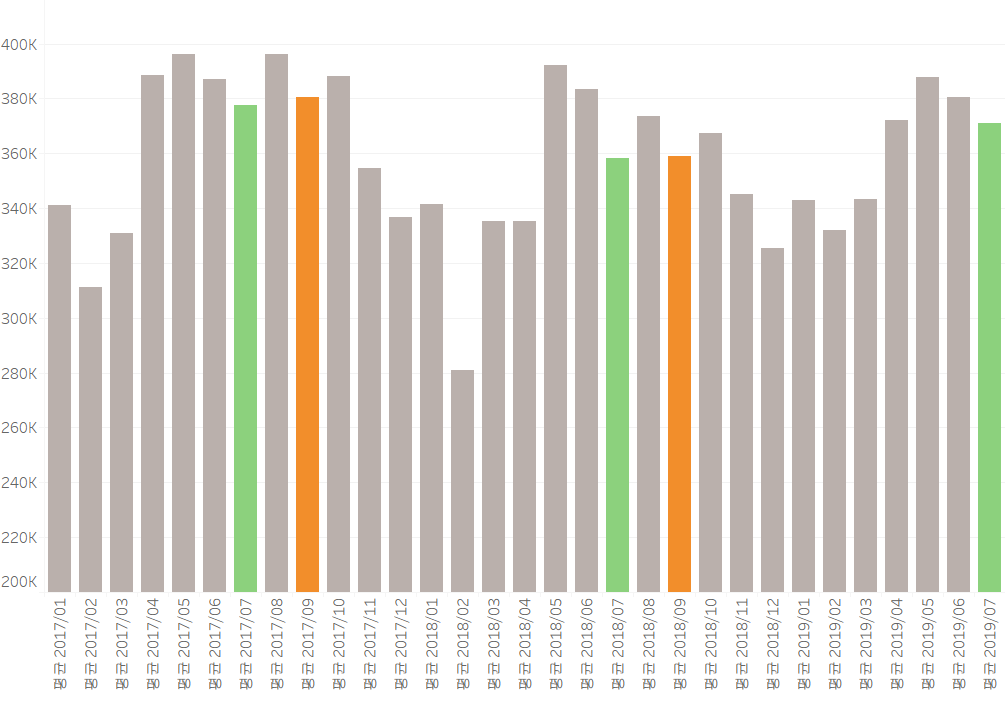

In [4]:
# 그래프로 비교해보니 매년 7월과 9월 값 유사 --> 2019-9월 test 값에 2019-7월 값 대입하기로!
Image("여객수월별평균비교.png") # code안에서 나오게 할 때

In [0]:
# 2019-9월 test 값에 2019-7월 값 대입
pass_arp[dt.datetime(2019,9,1)] = pass_arp[dt.datetime(2019,7,1)]
pass_odp[dt.datetime(2019,9,1)] = pass_odp[dt.datetime(2019,7,1)]

In [0]:
# 해당 행의 공항에 대응하는 여객 수 대입
pass_arp_li = []; pass_odp_li = []
for i in range(len(DATA)):
    pass_arp_li.append(pass_arp.loc[DATA['ARP'][i]][dt.datetime(DATA['SDT_YY'][i], DATA['SDT_MM'][i], 1)])
    pass_odp_li.append(pass_odp.loc[DATA['ODP'][i]][dt.datetime(DATA['SDT_YY'][i], DATA['SDT_MM'][i], 1)])

In [0]:
# 변수 생성
onehot['PASS_ARP'] = pass_arp_li
onehot['PASS_ODP'] = pass_odp_li

## 3. Train & Test 데이터 분리 및 file 저장 

In [ ]:
# DLY 변수와 feature engineering한 변수들 데이터 합치기
FINAL = pd.concat([onehot, DATA['DLY']], axis=1)

In [ ]:
# N과 Y로 되어 있는 DLY 변수를 0, 1로 변환
dly_li = []
for i in range(len(FINAL)):
    if FINAL['DLY'][i] == 'N':
        dly_li.append(0)
    elif FINAL['DLY'][i] == 'Y':
        dly_li.append(1)
    else:
        dly_li.append(FINAL['DLY'][i])

In [ ]:
# DLY 변수값 존재 여부에 따라 train / test 데이터 분할
TEST_FINAL = FINAL[FINAL['DLY'].isna()]
TRAIN_FINAL = FINAL[-FINAL['DLY'].isna()]

In [0]:
# 최종 데이터 파일로 저장
TEST_FINAL.to_csv('data/test_FINAL.csv', index=False, encoding='CP949')
TRAIN_FINAL.to_csv('data/train_FINAL.csv', index=False, encoding='CP949')